# Enter Gemini and Tavily API key

In [5]:
from getpass import getpass

Gemini_Key = getpass('Enter Gemini API Key: ')

Enter Gemini API Key:  ········


In [6]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key:  ········


In [7]:
import os

os.environ['GOOGLE_API_KEY'] = Gemini_Key
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Building Vector Database

In [8]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Initialize the Gemini (Google) embedding model
gemini_embed_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [1]:
# Getting data from wikipedia

!gdown 1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW

'gdown' is not recognized as an internal or external command,
operable program or batch file.


### Loading and Chunking Docs
Only getting docs related to football

In [9]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

wikipedia_filepath = 'simplewiki-2020-11-01.jsonl.gz'

docs = []
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        #Add all paragraphs
        #passages.extend(data['paragraphs'])
        #adding limited paragraphs
        docs.append({
                        'metadata': {
                                        'title': data.get('title'),
                                        'article_id': data.get('id')
                        },
                        'data': ' '.join(data.get('paragraphs')[0:2]) # restricting data to first 2 paragraphs to run later modules faster
        })

# We subset our data so we only use a subset of wikipedia documents to run things faster
docs = [doc for doc in docs for x in ['football']
              if x in doc['data'].lower().split()]
# Create docs
docs = [Document(page_content=doc['data'],
                 metadata=doc['metadata']) for doc in docs]
# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [10]:
len(chunked_docs)

7865

In [11]:
chunked_docs[:3]

[Document(metadata={'title': 'Figueirense F.C.', 'article_id': '85033'}, page_content='Figueirense Futebol Clube, also known as Figueirense, is a Brazilian football team in Florianópolis, Santa Catarina. In 1921, the club was founded as Figueirense Football Club.'),
 Document(metadata={'title': 'Real Sociedad', 'article_id': '85731'}, page_content='Real Sociedad de Fútbol is a Spanish football team. The team is in Donostia-San Sebastián in the Spanish province of Guipuzcoa. It was created in 1909. In the 2006/07 season, the team was in La Liga. After 40 years in this division, in the season 2007/08 Real Sociedad plays in Segunda División. The colors of the team are blue and white. Anoeta Stadium is the stadium of Real Sociedad. Anoeta has a capacity of 32 000. Anoeta Stadium was opened in 1993.'),
 Document(metadata={'title': 'ACF Fiorentina', 'article_id': '86084'}, page_content='ACF Fiorentina "(Associazione Calcio Fiorentina e Florentia Viola)",often called Fiorentina, is an Italian

### Creating Chroma Vector DB

In [12]:
from langchain_chroma import Chroma

chroma_db = Chroma.from_documents(documents=chunked_docs, collection_name="rag_db" , embedding=gemini_embed_model , 
                                  collection_metadata={"hnsw:space":"cosine"}, persist_directory="./wikipedia_db")  
                                  #uses euclidean by default

In [13]:
chroma_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold" , search_kwargs = {"k":3 , "score_threshold" : 0.3 } )


In [14]:
query = "What is LaLiga?"

top_3_docs = chroma_retriever.invoke(query)

top_3_docs

[Document(id='281356f7-9ed8-4d10-86eb-6d4522462f8d', metadata={'article_id': '52538', 'title': 'La Liga'}, page_content='La Liga, commonly known La Liga Santander for sponsor reasons, is a football league which is the top division in Spain.'),
 Document(id='e5b9de67-2366-47b6-9a17-841fb8a6f5a1', metadata={'title': 'Segunda División', 'article_id': '165351'}, page_content='Segunda División is a football league which is second division in Spain.'),
 Document(id='855bfa8a-c5e3-4c72-8bd2-f25e7ce17ae2', metadata={'title': 'German 3. Liga', 'article_id': '247404'}, page_content='The 3. Liga (3rd league) is a football league which is third division in Germany.')]

In [16]:
query = "What is Gemini API?"

top_3_docs = chroma_retriever.invoke(query)

top_3_docs

[Document(id='d41f8a15-e7cc-4a6e-8bbc-3a8e595f90e2', metadata={'title': 'Georgia national football team', 'article_id': '172954'}, page_content='Georgia national football team is the national football team of Georgia.'),
 Document(id='4c8d93a8-3738-4971-9072-570898eb7a66', metadata={'article_id': '332524', 'title': 'Florida Seminoles'}, page_content='The Florida Seminoles are a college football team that plays in the NCAA.'),
 Document(id='ea5ba666-6b79-4f4a-b011-a7085c67cba8', metadata={'title': 'Guyana national football team', 'article_id': '172983'}, page_content='Guyana national football team is the national football team of Guyana.')]

# Creating an LLM For Grading The Retrieved Documents

In [32]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI

# Creating Pydantic Data Model for LLM Output Format
class GradeDocuments(BaseModel):
    binary_score: str = Field ( description = "Documents are relevant to the question, 'yes' or 'no' " )

#LLM Model for Grading documents
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro" , temperature=0)

structured_llm_grader = llm.with_structured_output(GradeDocuments) 
# So basically output of this llm model will be structured to yes or no depending on relevancy of documents

In [33]:
# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}
                  """),
    ]
)
# Chat Prompt Template  formats the input (like document and question) into a structured prompt.

# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

# here we are creating a chain, This is a pipeline: first, the prompt is filled using the inputs (document, question) and passed to the LLM.
# Then, the LLM processes the prompt and returns a structured output, typically JSON or a parsed object.

In [34]:
query = "What is Champions League?"
top3_docs = chroma_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

The 2017–18 UEFA Champions League was the 63rd season of Europe's top club football tournament run by UEFA. It is the 26th season since it was renamed from the European Champion Clubs' Cup to the UEFA Champions League. <section begin=R16 />
GRADE: binary_score='yes'

The CAF Champions League is a football competition between the best club teams in Africa. The teams are selected because of good performances in matches.
GRADE: binary_score='yes'

The 2016-17 UEFA Champions League is the 62st season of Europe's premier club football tournament organised by UEFA. It is the 25th season since it was renamed from the European Champion Clubs' Cup to the UEFA Champions League. The 2017 UEFA Champions League Final was played at the Millennium Stadium in Cardiff, Wales. Real Madrid are the defending champions.
GRADE: binary_score='yes'



In [88]:
query = "what is fastapi?"
top3_docs = chroma_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

The Japanese national football team is the national football team of Japan.
GRADE: binary_score='no'

South Africa national football team is the national football team of South Africa.
GRADE: binary_score='no'

Singapore national football team is the national football team of Singapore.
GRADE: binary_score='no'



# Building RAG Chain for QA

In [35]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)

#LLM Model
gemini = ChatGoogleGenerativeAI(model="gemini-2.5-pro" , temperature=0)

# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# create QA RAG chain
'''
The reason we are sending context and question like this at start is because in previous(Grading) code, we wre just sending a single string instead
of list of documents, here since it is list of docs, we have to format it first.
'''
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    gemini
      |
    StrOutputParser()
)

#StrOutputParser is a LangChain component that parses the output of an LLM call into a simple string.

In [37]:
query = "who won the champions league in 2024?"
top3_docs = chroma_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

Based on the provided context, I don't know the answer to who won the Champions League in 2024.

The context provided mentions the 2017–18 UEFA Champions League, the CAF Champions League for African clubs, and the Primeira Liga in Portugal. There is no information regarding the winner of the 2024 Champions League.


In [ ]:
query = "What is Champions League?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

# Creating a Query Rephraser

In [74]:
# LLM for question rewriting
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro" , temperature=0)

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning. Don't output anything else. Just the improved query for web searching
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}

                     Formulate an improved question.
                  """,
        ),
    ]
)
# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())

In [75]:
query = "who won the champions league in 2024?"
question_rewriter.invoke({"question": query})

'2024 Champions League winner'

# Building Agentic RAG

#### 1) Initiliazing Web Search Tool

In [40]:
from langchain_community.tools.tavily_search import TavilySearchResults

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

C:\Users\desmo\AppData\Local\Temp\ipykernel_99972\3719633729.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tv_search = TavilySearchResults(max_results=3, search_depth='advanced',


#### 2) Graph State
Used to store and represent the state of the Agent Graph as we traverse through various nodes

In [76]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

### 3) Creating Functions for Each Nodes
#### 3.1) Retrive function for Retrieval from Vector DB

In [78]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """    
    print("---Retrieveal from Vector DB---")
    question = state['question']

    documents = chroma_retriever.invoke(question)

    return{'documents' : documents , 'question' : question}

#### 3.2) Document Grader
This will be used to determine whether the retrieved documents are relevant to the question by using an LLM Grader

Sets the web_search_needed flag as "Yes" if at least one document is not contextually relevant and sets it as "No" if all documents are contextually relevant to the given user query

In [79]:
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

#### 3.3) Rewrite Query
This will be used to rewrite the input query to produce a better question optimized for web search using an LLM

In [80]:
def rewrite_query(state):
    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    print("previous question" , question)
    better_question = question_rewriter.invoke({"question": question})
    print("better question" , better_question)

    return {"documents": documents, "question": better_question}

#### 3.4) Web Search
This will be used to search the web using the web search tool for the given query and retrieve some information which can be used as the context in RAG

In [81]:
from langchain.schema import Document

def web_search(state):
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    print(question)

    # Web search
    docs = tv_search.invoke(question)
    print(docs)
    web_results = "\n\n".join([d["content"] for d in docs])
    print(1)
    web_results = Document(page_content=web_results)
    print(2)

    documents.append(web_results)
    print(3)

    return {"documents": documents, "question": question}

#### 3.5) Decide to Generate
This will be used as a conditional function which will check the web_search_needed flag and decide if a web search is needed or a response should be generated and return the function name to be called

In [82]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

#### 3.6) Generate Answer
Standard LLM Response generation from query and context documents in a RAG system

In [83]:
def generate_answer(state):
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

### Building the Agent Graph

In [84]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

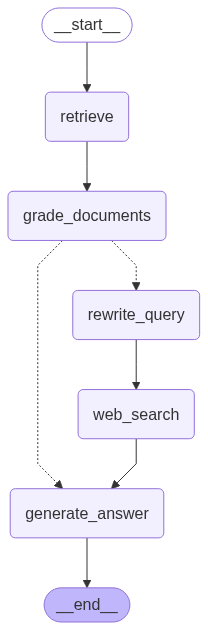

In [54]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [ ]:
response

In [ ]:
display(Markdown(response['generation']))

In [85]:
query = "who won the champions league in 2024?"
response = agentic_rag.invoke({"question": query})

---Retrieveal from Vector DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
previous question who won the champions league in 2024?
better question 2024 Champions League winner
---WEB SEARCH---
2024 Champions League winner
[{'title': 'UEFA Champions League 2023/24', 'url': 'https://www.uefa.com/uefachampionsleague/history/seasons/2024/', 'content': 'Image 37: LONDON, ENGLAND - JUNE 01: Toni Kroos, Luka Modric, Nacho Fernandez and Daniel Carvajal lift the trophy as he celebrates UCL title with the throphy after winning the UEFA Champions League 2023/24 final match between Borussia Dortmund v Real Madrid CF at Wembley Stadium on June 01, 2024 in London, England. (Photo by Antonio Villalba/Real Madrid via Getty Images)\n\nWinners Real Madrid\n\n Madrid comp

In [87]:
response

{'question': '2024 Champions League winner',
 'generation': 'Based on the provided context, the winner of the 2024 UEFA Champions League was **Real Madrid**.\n\nHere are the key details from the final match:\n\n*   **Winner:** Real Madrid\n*   **Opponent:** Borussia Dortmund\n*   **Final Score:** 2 - 0\n*   **Date:** June 1, 2024\n*   **Venue:** Wembley Stadium in London, England\n*   **Man of the Match:** Dani Carvajal (Real Madrid)\n\nThe context confirms that the Real Madrid squad lifted the trophy after winning the final match of the 2023/24 season.',
 'web_search_needed': 'Yes',
 'documents': [Document(metadata={}, page_content='Image 37: LONDON, ENGLAND - JUNE 01: Toni Kroos, Luka Modric, Nacho Fernandez and Daniel Carvajal lift the trophy as he celebrates UCL title with the throphy after winning the UEFA Champions League 2023/24 final match between Borussia Dortmund v Real Madrid CF at Wembley Stadium on June 01, 2024 in London, England. (Photo by Antonio Villalba/Real Madrid vi

In [86]:
display(Markdown(response['generation']))

Based on the provided context, the winner of the 2024 UEFA Champions League was **Real Madrid**.

Here are the key details from the final match:

*   **Winner:** Real Madrid
*   **Opponent:** Borussia Dortmund
*   **Final Score:** 2 - 0
*   **Date:** June 1, 2024
*   **Venue:** Wembley Stadium in London, England
*   **Man of the Match:** Dani Carvajal (Real Madrid)

The context confirms that the Real Madrid squad lifted the trophy after winning the final match of the 2023/24 season.

In [91]:
query = "who is the greatest european football club of all time based on trophies won?"
response = agentic_rag.invoke({"question": query})

---Retrieveal from Vector DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
previous question who is the greatest european football club of all time based on trophies won?
better question European football clubs ranked by total trophies
---WEB SEARCH---
European football clubs ranked by total trophies
[{'title': 'European Cup and UEFA Champions League records and statistics', 'url': 'https://en.wikipedia.org/wiki/European_Cup_and_UEFA_Champions_League_records_and_statistics', 'content': '| Image 7: GermanyBayern Munich | 6 | 5 | 1974, 1975, 1976, 2001, 2013, 2020 | 1982, 1987, 1999, 2010, 2012 |\n| Image 8: EnglandLiverpool | 6 | 4 | 1977, 1978, 1981, 1984, 2005, 2019 | 1985, 2007, 2018, 2022 |\n| Image 9: SpainBarcelona | 5 | 3 | 1992, 2006, 2009, 2011, 201

In [92]:
display(Markdown(response['generation']))

Based on the provided context, here is the ranking of European football clubs by the total number of UEFA Champions League/European Cup trophies won:

**Real Madrid** is the most successful club, having won the tournament 15 times.

Here is a detailed ranking of the clubs listed in the context:

*   **15 Trophies:**
    *   Real Madrid

*   **7 Trophies:**
    *   AC Milan

*   **6 Trophies:**
    *   Bayern Munich
    *   Liverpool

*   **5 Trophies:**
    *   Barcelona

*   **4 Trophies:**
    *   Ajax

*   **3 Trophies:**
    *   Inter Milan
    *   Manchester United

*   **2 Trophies:**
    *   Juventus
    *   Benfica
    *   Chelsea
    *   Nottingham Forest
    *   Porto

*   **1 Trophy:**
    *   Manchester City
    *   Borussia Dortmund
    *   Feyenoord
    *   Marseille
    *   Paris Saint-Germain (PSG)
    *   Aston Villa
    *   Hamburger SV
    *   Red Star Belgrade (Crvena Zvezda)
    *   FCSB (Steaua Bucharest)
    *   PSV Eindhoven
    *   Celtic

##### Tavily Response check

In [56]:
docs = tv_search.invoke("who won the champions league in 2024?")

docs


[{'title': 'UEFA Champions League 2023/24',
  'url': 'https://www.uefa.com/uefachampionsleague/history/seasons/2024/',
  'content': "Image 37: LONDON, ENGLAND - JUNE 01: Toni Kroos, Luka Modric, Nacho Fernandez and Daniel Carvajal lift the trophy as he celebrates UCL title with the throphy after winning the UEFA Champions League 2023/24 final match between Borussia Dortmund v Real Madrid CF at Wembley Stadium on June 01, 2024 in London, England. (Photo by Antonio Villalba/Real Madrid via Getty Images)\n\nWinners Real Madrid\n\n Madrid complete unbeaten campaign with Dortmund scalp \n\nOverviewMatchesGroupsStatsClubs [...] Image 36: LONDON, ENGLAND - JUNE 01: Real Madrid squad lift the trophy as he celebrates UCL title with the throphy after winning the UEFA Champions League 2023/24 final match between Borussia Dortmund v Real Madrid CF at Wembley Stadium on June 01, 2024 in London, England. (Photo by Antonio Villalba/Real Madrid via Getty Images) [...] Image 34: LONDON, ENGLAND - JUNE 

In [58]:
web_results = "\n\n".join([d["content"] for d in docs])


In [59]:
web_results

'Image 37: LONDON, ENGLAND - JUNE 01: Toni Kroos, Luka Modric, Nacho Fernandez and Daniel Carvajal lift the trophy as he celebrates UCL title with the throphy after winning the UEFA Champions League 2023/24 final match between Borussia Dortmund v Real Madrid CF at Wembley Stadium on June 01, 2024 in London, England. (Photo by Antonio Villalba/Real Madrid via Getty Images)\n\nWinners Real Madrid\n\n Madrid complete unbeaten campaign with Dortmund scalp \n\nOverviewMatchesGroupsStatsClubs [...] Image 36: LONDON, ENGLAND - JUNE 01: Real Madrid squad lift the trophy as he celebrates UCL title with the throphy after winning the UEFA Champions League 2023/24 final match between Borussia Dortmund v Real Madrid CF at Wembley Stadium on June 01, 2024 in London, England. (Photo by Antonio Villalba/Real Madrid via Getty Images) [...] Image 34: LONDON, ENGLAND - JUNE 01: Gregor Kobel and Mats Hummels of Borussia Dortmund attempt to stop the ball, as Daniel Carvajal of Real Madrid scores his team\'